In [1]:
from pyspark.sql import SparkSession

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

spark = SparkSession \
    .builder \
    .appName("Python Spark GBTRegressor example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/09 18:16:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Random state 

Random state is used to set the seed for the random generator so that we can ensure that the results that we get can be reproduced. Because of the nature of splitting the data in train and test is randomised you would get different data assigned to the train and test data unless you can control for the random factor.

For example, imagine you have numbers: 1,2,3,4,5 and you want to select two random numbers. Without using a random_state you would get different things: i.e. first 2,5 then 3,4 and so on.
When you control the random generator by setting the random state to 0, 1 or another number, everyone would get the same random numbers generated: i.e random_state=1 then the random numbers are 1,3 and everyone who will pick two random numbers using random_state=1 from 1,2,3,4,5 will get the same two numbers as you: 1,3.

In [2]:
from sklearn.utils import check_random_state

### Generate an 100 element array from 0 to 99; generate 100 element array of y, each y element is a random number

In [3]:
n = 100
x = np.arange(n)
rs = check_random_state(0)
y = rs.randint(-50, 50, size=(n,)) + 50.0 * np.log1p(np.arange(n))

### Create a list of 100 lists

In [4]:
xList=x.tolist()
yList=y.tolist()
xyList=[[i,j] for i, j in zip(xList,yList)]

### Plot data out

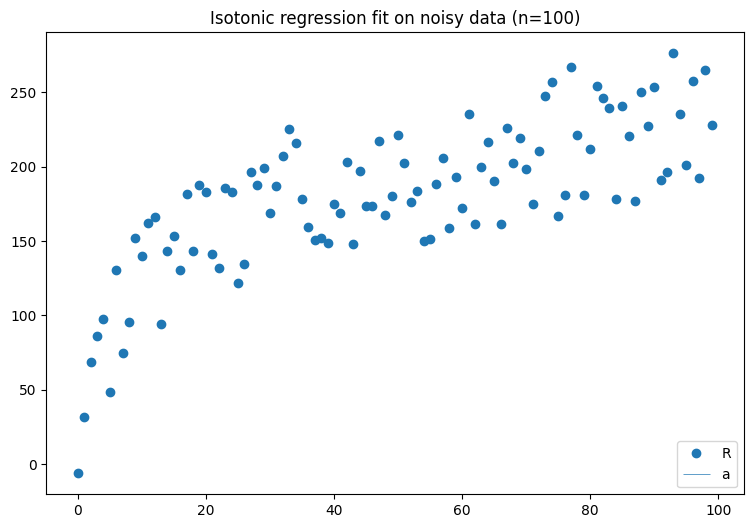

In [29]:
segments = [[[i, y[i]]] for i in range(n)]
lc = LineCollection(segments, zorder=0)
lc.set_array(np.ones(len(y)))
lc.set_linewidths(np.full(n, 0.5))


fig, (ax0) = plt.subplots(ncols=1, figsize=(9, 6))

ax0.plot(xList, yList, "C0.", markersize=12)
ax0.add_collection(lc)
ax0.legend(("Raw data"), loc="lower right")
ax0.set_title("Isotonic regression fit on noisy data (n=%d)" % n)
plt.show()



### generate spark SQL dataframe

In [6]:
df=spark.createDataFrame(xyList, ['x', 'label'])

In [7]:
df.show(5)

+---+------------------+
|  x|             label|
+---+------------------+
|  0|              -6.0|
|  1|31.657359027997266|
|  2| 68.93061443340548|
|  3| 86.31471805599453|
|  4| 97.47189562170502|
+---+------------------+
only showing top 5 rows



In [8]:
df.describe().show()

+-------+------------------+------------------+
|summary|                 x|             label|
+-------+------------------+------------------+
|  count|               100|               100|
|   mean|              49.5|180.09968777778175|
| stddev|29.011491975882016|50.951996452433555|
|    min|                 0|              -6.0|
|    max|                99| 276.1647391135002|
+-------+------------------+------------------+



### Manually transform vector features

Convert the data to dense vector (features and label)

In [9]:
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors

transformed=df.rdd.map(lambda r: [r[0], Vectors.dense(r[:-1]),r[-1]]).toDF(['rawfeatures','features','label'])
transformed.show(5)

+-----------+--------+------------------+
|rawfeatures|features|             label|
+-----------+--------+------------------+
|          0|   [0.0]|              -6.0|
|          1|   [1.0]|31.657359027997266|
|          2|   [2.0]| 68.93061443340548|
|          3|   [3.0]| 86.31471805599453|
|          4|   [4.0]| 97.47189562170502|
+-----------+--------+------------------+
only showing top 5 rows



### any feature columns having 4 or fewer distinct values, consider them categorical and index them for better training, as result, now the feature vector is indexedFeatures

Deal with the Categorical variables

In [10]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

featureIndexer = VectorIndexer(inputCol="features", \
                               outputCol="indexedFeatures",\
                               maxCategories=4).fit(transformed)

data = featureIndexer.transform(transformed)
data.show(5,True)

+-----------+--------+------------------+---------------+
|rawfeatures|features|             label|indexedFeatures|
+-----------+--------+------------------+---------------+
|          0|   [0.0]|              -6.0|          [0.0]|
|          1|   [1.0]|31.657359027997266|          [1.0]|
|          2|   [2.0]| 68.93061443340548|          [2.0]|
|          3|   [3.0]| 86.31471805599453|          [3.0]|
|          4|   [4.0]| 97.47189562170502|          [4.0]|
+-----------+--------+------------------+---------------+
only showing top 5 rows



### Split the data into training and test sets (40% held out for testing)

In [11]:
# Split the data into training and test sets (40% held out for testing)
(trainingData, testData) = data.randomSplit([0.6, 0.4])

trainingData.show(5)
testData.show(5)

+-----------+--------+------------------+---------------+
|rawfeatures|features|             label|indexedFeatures|
+-----------+--------+------------------+---------------+
|          0|   [0.0]|              -6.0|          [0.0]|
|          1|   [1.0]|31.657359027997266|          [1.0]|
|          3|   [3.0]| 86.31471805599453|          [3.0]|
|          8|   [8.0]| 95.86122886681098|          [8.0]|
|         13|  [13.0]|  93.9528664807629|         [13.0]|
+-----------+--------+------------------+---------------+
only showing top 5 rows

+-----------+--------+------------------+---------------+
|rawfeatures|features|             label|indexedFeatures|
+-----------+--------+------------------+---------------+
|          2|   [2.0]| 68.93061443340548|          [2.0]|
|          4|   [4.0]| 97.47189562170502|          [4.0]|
|          5|   [5.0]|48.587973461402754|          [5.0]|
|          6|   [6.0]|130.29550745276566|          [6.0]|
|          7|   [7.0]| 74.97207708399179|      

### Training with LinearRegression First

In [12]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'indexedFeatures', labelCol='label', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(trainingData)
print("Coefficients: " + str(lr_model.coefficients[0]))
print("Intercept: " + str(lr_model.intercept))

23/05/09 18:18:17 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/05/09 18:18:17 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


Coefficients: 1.5342323583688375
Intercept: 103.48134625758412


In [13]:
lr_predictions = lr_model.transform(testData)
lr_predictions.show(5)

+-----------+--------+------------------+---------------+------------------+
|rawfeatures|features|             label|indexedFeatures|        prediction|
+-----------+--------+------------------+---------------+------------------+
|          2|   [2.0]| 68.93061443340548|          [2.0]| 106.5498109743218|
|          4|   [4.0]| 97.47189562170502|          [4.0]|109.61827569105947|
|          5|   [5.0]|48.587973461402754|          [5.0]| 111.1525080494283|
|          6|   [6.0]|130.29550745276566|          [6.0]|112.68674040779715|
|          7|   [7.0]| 74.97207708399179|          [7.0]|114.22097276616599|
+-----------+--------+------------------+---------------+------------------+
only showing top 5 rows



### Training with IsotonicRegression next for comparison

Fit IsotonicRegression Regression Model with IsotonicRegression

In [14]:
# Import IsotonicRegression class
from pyspark.ml.regression import IsotonicRegression

# Define LinearRegression algorithm
iso = IsotonicRegression(featuresCol="indexedFeatures", labelCol="label") 
iso_model=iso.fit(trainingData)


Make predictions

In [15]:
iso_predictions = iso_model.transform(testData)

# Select example rows to display.
iso_predictions.show(5)

+-----------+--------+------------------+---------------+------------------+
|rawfeatures|features|             label|indexedFeatures|        prediction|
+-----------+--------+------------------+---------------+------------------+
|          2|   [2.0]| 68.93061443340548|          [2.0]|58.986038541995896|
|          4|   [4.0]| 97.47189562170502|          [4.0]| 88.03318397955302|
|          5|   [5.0]|48.587973461402754|          [5.0]|  89.7516499031115|
|          6|   [6.0]|130.29550745276566|          [6.0]| 91.47011582666997|
|          7|   [7.0]| 74.97207708399179|          [7.0]| 93.18858175022845|
+-----------+--------+------------------+---------------+------------------+
only showing top 5 rows



### Evaluation, appears IsotonicRegression does better than Linear Regression, although both are less than desired

In [16]:
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(lr_predictions)
print("Linear Regression Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Linear Regression Root Mean Squared Error (RMSE) on test data = 34.2287


In [17]:
evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="r2")
print("Linear Regression R Squared (R2) on test data = %g" % evaluator.evaluate(lr_predictions))

Linear Regression R Squared (R2) on test data = 0.462945


In [18]:
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(iso_predictions)
print("Isotonic Regression Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Isotonic Regression Root Mean Squared Error (RMSE) on test data = 33.9378


In [19]:
evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="r2")
print("Isotonic Regression R Squared (R2) on test data = %g" % evaluator.evaluate(iso_predictions))

Isotonic Regression R Squared (R2) on test data = 0.472036


### Plot the predictions for both Linear Regression and Isotonic Regression out

In [20]:
X=[]
Y=[]
YHat=[]
for i in iso_predictions.rdd.collect():
    X.append(i[0])
    Y.append(i[2])
    YHat.append(i[4])

YLR=[]
for i in lr_predictions.rdd.collect():
    YLR.append(i[4])


Text(0.5, 1.0, 'Isotonic regression fit on noisy data (n=100)')

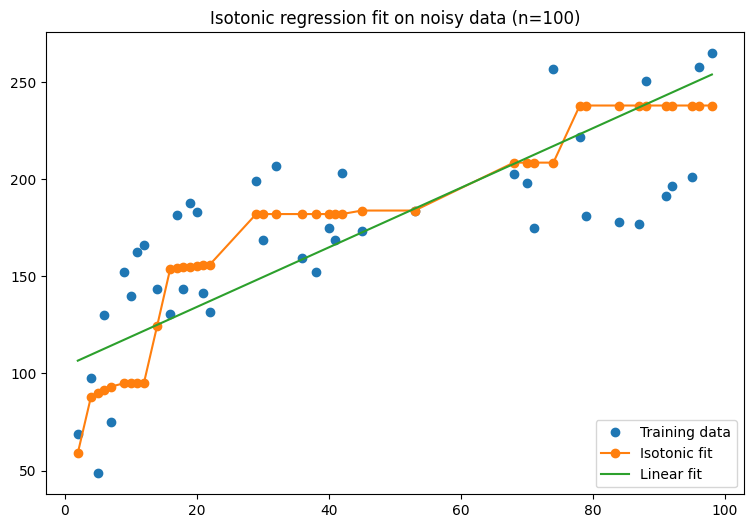

In [30]:
segments = [[[i, y[i]]] for i in range(n)]
lc = LineCollection(segments, zorder=0)
lc.set_array(np.ones(len(y)))
lc.set_linewidths(np.full(n, 0.5))

fig, (ax0) = plt.subplots(ncols=1, figsize=(9, 6))

ax0.plot(X, Y, "C0.", markersize=12)
ax0.plot(X, YHat, "C1.-", markersize=12)
ax0.plot(X, YLR, "C2-")
ax0.add_collection(lc)
ax0.legend(("Training data", "Isotonic fit", "Linear fit"), loc="lower right")
ax0.set_title("Isotonic regression fit on noisy data (n=%d)" % n)

#x_test = np.linspace(-10, 110, 1000)
#ax1.plot(x_test, ir.predict(x_test), "C1-")
#ax1.plot(ir.X_thresholds_, ir.y_thresholds_, "C1.", markersize=12)
#ax1.set_title("Prediction function (%d thresholds)" % len(ir.X_thresholds_))

#plt.show()